In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tools import add_constant
from statsmodels.regression.rolling import RollingOLS
from datetime import timedelta
from backtesting import Backtest

import redshift_connector

In [5]:
%%time

with redshift_connector.connect(
    host = 'project-poseidon.cpsnf8brapsd.us-west-2.redshift.amazonaws.com',
    database = 'token_price',

    user = 'administrator',
    password = 'Free2play2'
) as conn:
    with conn.cursor() as cursor:
        query = """
        SELECT
            time_period_end,
            price_close,
            asset_id_base,
            asset_id_quote,
            exchange_id
        FROM eth.stg_price_data_1h
        WHERE
            asset_id_base || '_' || asset_id_quote || '_' || exchange_id IN ('WBTC_ETH_BINANCE', 'BNB_ETH_BINANCE')
        ORDER BY time_period_end 
        """

        cursor.execute(query)
        tuples = cursor.fetchall()

        # Return queried data as a DataFrame
        df = pd.DataFrame(tuples, columns = ['time_period_end', 'price_close', 'asset_id_base', 'asset_id_quote', 'exchange_id'])
        df['price_close'] = df['price_close'].astype(float)

df

CPU times: user 279 ms, sys: 25.7 ms, total: 305 ms
Wall time: 9.01 s


,time_period_end,price_close,asset_id_base,asset_id_quote,exchange_id
0,2017-08-09 10:00:00,0.000840,BNB,ETH,BINANCE
1,2017-08-09 11:00:00,0.000805,BNB,ETH,BINANCE
2,2017-08-09 12:00:00,0.000796,BNB,ETH,BINANCE
3,2017-08-09 13:00:00,0.000802,BNB,ETH,BINANCE
4,2017-08-09 14:00:00,0.000819,BNB,ETH,BINANCE
...,...,...,...,...,...
61359,2022-09-01 04:00:00,12.930000,WBTC,ETH,BINANCE
61360,2022-09-01 05:00:00,0.179000,BNB,ETH,BINANCE
61361,2022-09-01 05:00:00,12.910000,WBTC,ETH,BINANCE
61362,2022-09-01 06:00:00,0.179100,BNB,ETH,BINANCE


In [8]:
%%time

df['symbol_id'] = df['asset_id_base'] + '_' + df['asset_id_quote'] + '_' + df['exchange_id']
pivot = df.pivot_table(index = 'time_period_end', columns = 'symbol_id', values = ['price_close']).dropna()
pivot

CPU times: user 41.9 ms, sys: 14.3 ms, total: 56.3 ms
Wall time: 59.2 ms


price_close                 
symbol_id           BNB_ETH_BINANCE WBTC_ETH_BINANCE
time_period_end                                     
2020-08-31 09:00:00        0.055189          28.0171
2020-08-31 10:00:00        0.054930          27.4460
2020-08-31 11:00:00        0.054286          27.1300
2020-08-31 12:00:00        0.053968          27.0499
2020-08-31 13:00:00        0.053480          26.9908
...                             ...              ...
2022-09-01 02:00:00        0.179100          12.9000
2022-09-01 03:00:00        0.178400          12.9300
2022-09-01 04:00:00        0.179100          12.9300
2022-09-01 05:00:00        0.179000          12.9100
2022-09-01 06:00:00        0.179100          12.8900

[17216 rows x 2 columns]

In [9]:
df.columns

Index(['time_period_end', 'price_close', 'asset_id_base', 'asset_id_quote',
       'exchange_id', 'symbol_id'],
      dtype='object')

In [ ]:
%%time

def run_cointegration_for_token(symbol_id, start_date, end_date, p_val_thresh = 0.05):
        
    cointegrated_tokens = []
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
                
    unique_pairs = np.unique([p[1] for p in pivot.columns])
    
    for pair in unique_pairs:
        if 'ETH_USD' in pair or pair == symbol_id:
            continue
            
        price_data = pivot['price_close'][pair].dropna()
        price_data_index = np.array(price_data.index.to_list())
        price_data = price_data[(price_data_index >= start_date) & (price_data_index <= end_date)].to_frame()
        
        m = price_data.merge(token_data, on = 'time_period_end', how = 'inner')
        
        if len(m) == 0:
            continue
            
        X = m[symbol_id]
        X = add_constant(X)
        
        Y = m[pair]
        Y = add_constant(Y)
                
        ols1 = sm.OLS(Y[pair], X).fit()
        ols2 = sm.OLS(X[symbol_id], Y).fit()
        
        best_ols = min([ols1, ols2], key = lambda x: adfuller(x.resid)[1])
        best_p_val = adfuller(best_ols.resid)[1]
        
        if best_ols == ols1 and best_p_val <= p_val_thresh:
            coint_dict = {
                'start':m.index[0],
                'end':m.index[-1],
                'X':symbol_id,
                'Y':pair
            }
            cointegrated_tokens.append(coint_dict)
            
        elif best_ols == ols2 and best_p_val <= p_val_thresh:
            coint_dict = {
                'start':m.index[0],
                'end':m.index[-1],
                'X':pair,
                'Y':symbol_id
            }
            cointegrated_tokens.append(coint_dict)
                    
    return cointegrated_tokens
                

cointegrated_tokens = run_cointegration_for_token(
    'ETH_USD_COINBASE', 
    start_date = '2021-09-01',
    end_date = '2022-09-01'
)


In [ ]:
cointegrated_tokens

In [12]:
X = pivot['price_close']['WBTC_ETH_BINANCE'].dropna().to_frame()
Y = pivot['price_close']['BNB_ETH_BINANCE'].dropna().to_frame()

m = X.merge(Y, on = 'time_period_end', how = 'inner')

rolling_hedge_ratios = (
    RollingOLS(
        endog = m[Y.columns[0]], 
        exog = add_constant(m[X.columns[0]]),
        window = 24*7
    )
).fit().params[X.columns[0]]
    
rolling_spread = m[Y.columns[0]] - rolling_hedge_ratios * m[X.columns[0]]

rolling_mean = rolling_spread.rolling(window = 24*7).mean()
rolling_std = rolling_spread.rolling(window = 24*7).std()
rolling_z_score = (rolling_spread - rolling_mean) / rolling_std

Text(0.5, 0, '')

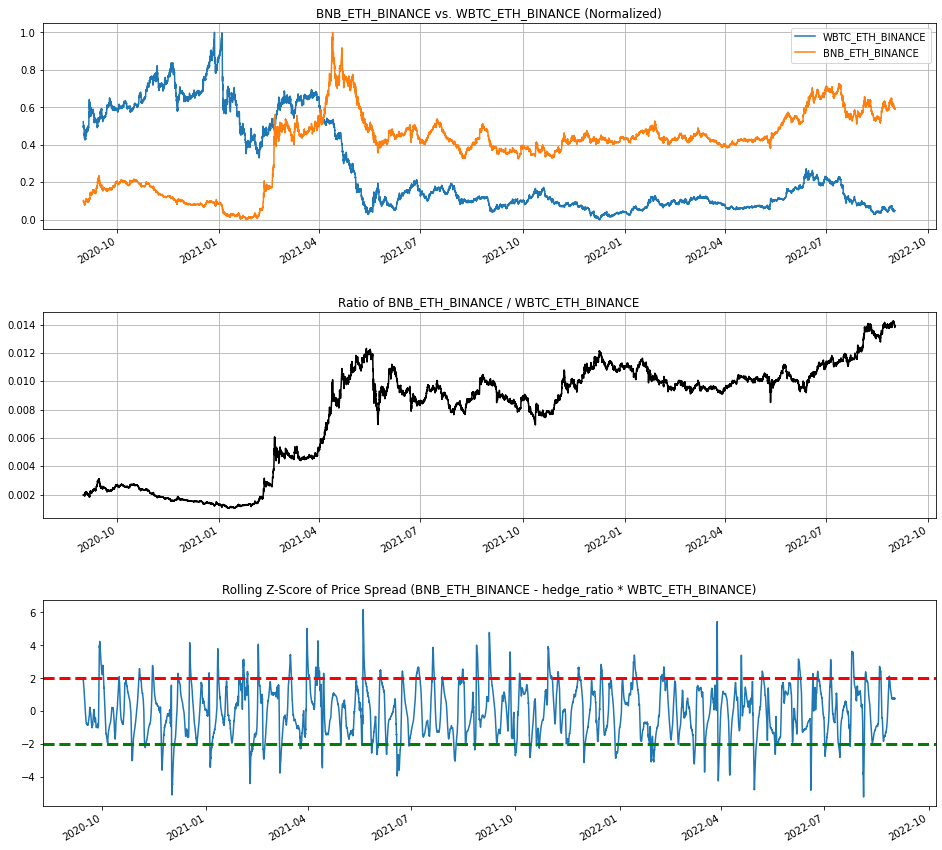

In [13]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 16))
fig.subplots_adjust(hspace=.4)

x = m[X.columns[0]]
y = m[Y.columns[0]]
z = rolling_z_score

plt.subplot(3, 1, 1)
((x - x.min()) / (x.max() - x.min())).plot(label = X.columns[0])
((y - y.min()) / (y.max() - y.min())).plot(label = Y.columns[0], grid = True)
plt.title('{} vs. {} (Normalized)'.format(Y.columns[0], X.columns[0]))
plt.legend()
plt.xlabel('')

plt.subplot(3, 1, 2)
(y / x).plot(title = 'Ratio of {} / {}'.format(Y.columns[0], X.columns[0]), c = 'black', grid = True)
plt.xlabel('')

plt.subplot(3, 1, 3)
z.plot(title = 'Rolling Z-Score of Price Spread ({} - hedge_ratio * {})'.format(Y.columns[0], X.columns[0]))
plt.axhline(-2, c = 'green', linestyle = '--', lw = 3)
plt.axhline(2, c = 'red', linestyle = '--', lw = 3)
plt.xlabel('')

In [31]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools import add_constant
from backtesting.lib import crossover, cross
from datetime import timedelta

class PairsTradingBacktester:
    # BACKTESTING PARAMETERS

    # Window size to calculate the rolling z score
    # of the price spread
    z_window = 96

    # Window size to calculate the rollling hedge ratios 
    hedge_ratio_window = 168

    # Value of price spread rolling z score to initiate 
    # a buy
    z_score_upper_thresh = 2

    # Value of price spread rolling z score to initiate 
    # a sell
    z_score_lower_thresh = -2.5

    def __init__(self, 
                 symbol_id_1, 
                 symbol_id_2, 
                 start_date, 
                 end_date, 
                 initial_capital = 10_000, 
                 pct_capital_per_trade = 0.1,
                 comission = 0.01):
        """
        symbol_id_1 - Token we're shorting in the backtest

        symbol_id_2 - Token we're longing in the backtest

        start_date - Start date of the backtest

        end_date - End date of the backtest
        
        initial_captial - Starting capital of the backtest
        
        pct_capital_per_trade - Percent of available capital to allocate to each trade
        
        comission - Percentage deducted from each buy and sell order made
        """

        self.symbol_id_1 = symbol_id_1
        self.symbol_id_2 = symbol_id_2

        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        
        self.initial_capital = initial_capital
        self.pct_capital_per_trade = pct_capital_per_trade
        self.comission = comission

        # Fetch data required for backtest
        self.data = self.get_data(symbol_id_1, symbol_id_2)
        
        # Backtest initialized w/ no position
        self.position = 0

        # Number of units long in our current position
        self.curr_position_long_units = 0

        # Number of units short in our current position
        self.curr_position_short_units = 0

        # Trades executed throughout the backtest
        self.trades = pd.DataFrame(columns = ['entry_date', 'exit_date', self.symbol_id_2, self.symbol_id_1])

        #  Long and short positions at each timestep
        self.positions = None

        # PnL in dollars at each timestep
        self.pnl = None

        # Equity at each timestep
        self.equity = None

        # Percent returns at each timestep
        self.returns = None

        # Performance metrics for backtest
        self.performance_metrics = None

        
    ################################# HELPER METHODS #################################
    
    def __rolling_hedge_ratios(self):
        return RollingOLS(
            endog = self.data[self.symbol_id_2].to_frame(),
            exog = add_constant(self.data[self.symbol_id_1].to_frame()),
            window = self.hedge_ratio_window
        ).fit().params[self.symbol_id_1]
    
    def __rolling_spread(self):
        return self.data[self.symbol_id_2].values - self.data['rolling_hedge_ratio'].values * self.data[self.symbol_id_1].values
    
    def __rolling_spread_z_score(self):
        rolling_spread = self.data['rolling_spread']
        return (rolling_spread - rolling_spread.rolling(window = self.z_window).mean()) / rolling_spread.rolling(window = self.z_window).std()
    
    def __generate_entry_signals(self):
        entry_signals = []
        for i in range(len(self.data)):
            if i == 0:
                entry_signals.append(0)
                continue

            relevant_data = self.data.loc[self.data.index[i - 1]:self.data.index[i], 'rolling_spread_z_score']
                
            if (not crossover(relevant_data, self.z_score_lower_thresh) and
                cross(relevant_data, self.z_score_lower_thresh)):
                entry_signals.append(1)
            else:
                entry_signals.append(0)

        return entry_signals

    def __generate_exit_signals(self):
        exit_signals = []
        for i in range(len(self.data)):
            if i == 0:
                exit_signals.append(0)
                continue
                
            if crossover(self.data.loc[self.data.index[i - 1]:self.data.index[i], 'rolling_spread_z_score'], self.z_score_upper_thresh):
                exit_signals.append(1)
            else:
                exit_signals.append(0)

        return exit_signals
    
    def __close_trade(self, positions, i):
        # Set long and short position amount for current timestamp to 0
        # to simulate closing the trade
        positions.loc[self.data.index[i], self.symbol_id_2] = 0
        positions.loc[self.data.index[i], self.symbol_id_1] = 0
        
        # Set the exit date of the current trade to the current timestamp
        self.trades.loc[len(self.trades) - 1,'exit_date'] = self.data.index[i]

        # Indicate we're no longer in a trade
        self.position = 0
        
        # Calculate pnl and pnl % from trade

        # Entry and exit dates of most current trade
        start = self.trades.loc[len(self.trades) - 1,'entry_date']
        end = self.trades.loc[len(self.trades) - 1,'exit_date']

        # Calculate the PnL from the long position
        start_value_long = self.data.loc[start, self.symbol_id_2] * positions.loc[start, self.symbol_id_2]
        end_value_long = self.data.loc[end, self.symbol_id_2] * positions.loc[start, self.symbol_id_2]
        long_pnl = end_value_long - start_value_long

        # Calculate the PnL from the short position
        start_value_short = self.data.loc[start, self.symbol_id_1] * positions.loc[start, self.symbol_id_1]
        end_value_short = self.data.loc[end, self.symbol_id_1] * positions.loc[start, self.symbol_id_1]
        short_pnl = start_value_short - end_value_short

        # Calculate the PnL from the entire trade 
        trade_pnl = long_pnl + short_pnl
        total_investment = start_value_long + start_value_short
        trade_pnl_pct = trade_pnl / total_investment
        
        # Set the PnL and PnL % of the current trade
        self.trades.loc[len(self.trades) - 1, 'pnl_pct'] = trade_pnl_pct
        self.trades.loc[len(self.trades) - 1, 'pnl'] = trade_pnl
        
        return end_value_long + end_value_short

    def __generate_positions(self):
        # Long and short positions throughout backtest
        positions = pd.DataFrame(index = self.data.index, columns = [self.symbol_id_2, self.symbol_id_1])
        
        # Tracking available capital throughout backtest
        curr_capital = self.initial_capital
        
        # Iterate through each timestamp of dataset
        for i in range(len(self.data)):  

            # Retrieve entry and exit signals at current timestamp          
            entry_signal = self.data.loc[self.data.index[i], 'entry_signals']
            exit_signal = self.data.loc[self.data.index[i], 'exit_signals']

            # If not in a trade at current timestamp
            if not self.position:

                # If entry signal is received
                if entry_signal: 
                    
                    # If on the last timestamp then don't open a trade
                    if i == len(self.data) - 1:
                        continue
                        
                    # If rolling hedge ratio is negative then don't open a trade
                    if self.data.loc[self.data.index[i], 'rolling_hedge_ratio'] <= 0:
                        continue
                    
                    # Amount of dollars to allocate to the long position
                    long_allocation = (1 - self.comission) * curr_capital * self.pct_capital_per_trade / 2
                    
                    # Number of units of token2 to long
                    units_long = long_allocation / self.data.loc[self.data.index[i], self.symbol_id_2]
                    
                    # Amount of dollars to allocate to the short position
                    short_allocation = (1 - self.comission) * curr_capital * self.pct_capital_per_trade / 2

                    # Number of units of token1 to short
                    units_short = short_allocation / self.data.loc[self.data.index[i], self.symbol_id_1]

                    # Set long and short position amounts for current timestamp
                    positions.loc[self.data.index[i], self.symbol_id_2] = units_long
                    positions.loc[self.data.index[i], self.symbol_id_1] = units_short
                    
                    curr_capital -= (long_allocation + short_allocation)
                    
                    # Initialize a new trade and append it to the trades DataFrame
                    new_trade = {
                        'entry_date':self.data.index[i],
                        'exit_date':np.nan,
                         self.symbol_id_2:units_long,
                         self.symbol_id_1:units_short,
                        'pnl':np.nan,
                        'pnl_pct':np.nan
                    }
    
                    new_trade = pd.DataFrame(new_trade, index = [0])
                    self.trades = pd.concat([self.trades, new_trade], ignore_index = True)
                    
                    # Track number of units in current long and short position
                    self.curr_position_long_units = units_long
                    self.curr_position_short_units = units_short
                    
                    # Indicate we're in a trade now
                    self.position = 1

                # If exit signal is received
                else:

                    # Set long and short position amounts for current timestamp to 0
                    # since we're not in a trade
                    positions.loc[self.data.index[i], self.symbol_id_2] = 0
                    positions.loc[self.data.index[i], self.symbol_id_1] = 0

            # If in a trade at current timestamp
            else:

                # If exit signal is received
                if exit_signal:

                    # Close the current trade
                    end_trade_amount = self.__close_trade(positions = positions, i = i)
                    curr_capital += end_trade_amount

                # If entry signal is received
                else:

                    # Set long and short position amounts for current timestamp to
                    # the amounts in the current trade since we haven't exited the
                    # current trade yet
                    positions.loc[self.data.index[i], self.symbol_id_2] = self.curr_position_long_units
                    positions.loc[self.data.index[i], self.symbol_id_1] = self.curr_position_short_units
            
            # If the backtest reaches the final timestamp and the current trade hasn't
            # been exited yet 
            if i == len(self.data) - 1 and len(self.trades) > 0 and type(self.trades.loc[len(self.trades) - 1, 'exit_date']) == type(np.nan):

                # Close the current trade
                end_trade_amount = self.__close_trade(positions = positions, i = i)
                curr_capital += end_trade_amount

        return positions
    
    def __generate_pnl(self):
        pnl_data = pd.DataFrame(index = self.data.index, columns = ['pnl']).fillna(0)
        
        for index, trade in self.trades.iterrows():
            entry_date = trade['entry_date']
            exit_date = trade['exit_date']
            
            units_long = trade[self.symbol_id_2]
            units_short = trade[self.symbol_id_1]
            
            trade_period = self.data.loc[entry_date:exit_date].copy()
            
            trade_period['long_pnl'] = trade_period[self.symbol_id_2].diff() * units_long
            trade_period['short_pnl'] = -trade_period[self.symbol_id_1].diff() * units_short
            trade_period['total_pnl'] = trade_period['long_pnl'] + trade_period['short_pnl']

            for date in trade_period.index:
                pnl_data.loc[date, 'pnl'] = trade_period.loc[date, 'total_pnl']
                
        return pnl_data

    def __generate_equity_curve(self):
        return (self.initial_capital + self.pnl.cumsum()).rename({'pnl':'equity'}, axis = 1)
    
    def __generate_returns(self):
        return (self.equity / self.initial_capital).rename({'equity':'return'}, axis = 1)
                
    ################################# HELPER METHODS #################################
    
    def get_data(self, symbol_id_1, symbol_id_2):
        base_1, quote_1, exchange_id_1 = symbol_id_1.split('_')
        base_2, quote_2, exchange_id_2 = symbol_id_2.split('_')
        
        with redshift_connector.connect(
            host = 'project-poseidon.cpsnf8brapsd.us-west-2.redshift.amazonaws.com',
            database = 'token_price',
            user = 'administrator',
            password = 'Free2play2'
        ) as conn:
            with conn.cursor() as cursor:
                query = """
                WITH symbol_id_1 AS (
                    SELECT 
                        time_period_end,
                        price_close
                    FROM token_price.eth.stg_price_data_1h
                    WHERE
                        asset_id_base = '{}' AND
                        asset_id_quote = '{}' AND
                        exchange_id = '{}'
                ), symbol_id_2 AS (
                    SELECT 
                        time_period_end,
                        price_close
                    FROM token_price.eth.stg_price_data_1h
                    WHERE
                        asset_id_base = '{}' AND
                        asset_id_quote = '{}' AND
                        exchange_id = '{}'
                )
                
                SELECT
                    s1.time_period_end,
                    s1.price_close AS {},
                    s2.price_close AS {}
                FROM symbol_id_1 s1 INNER JOIN symbol_id_2 s2
                        ON s1.time_period_end = s2.time_period_end
                ORDER BY s1.time_period_end 
                """.format(
                    base_1, quote_1, exchange_id_1,
                    base_2, quote_2, exchange_id_2,
                    self.symbol_id_1, self.symbol_id_2
                )
        
                cursor.execute(query)
                tuples = cursor.fetchall()
        
                # Return queried data as a DataFrame
                df = pd.DataFrame(tuples, columns = ['time_period_end', self.symbol_id_1, self.symbol_id_2]).set_index('time_period_end')
                df = df.astype(float)

                return df
    
    def calculate_performance_metrics(self):
        ########################### HELPER FUNCTIONS ####################################
        def exposure_time(duration):
            exposure = timedelta(days = 0, hours = 0)

            for i in range(len(self.trades)):
                entry_date = pd.to_datetime(self.trades.loc[i, 'entry_date'])
                exit_date = pd.to_datetime(self.trades.loc[i, 'exit_date'])
                trade_duration = exit_date - entry_date
                exposure += trade_duration
            
            return round(exposure / duration * 100, 2)

        def buy_and_hold_return():
            token1_start_value = self.data.loc[self.data.index[0], self.symbol_id_1]
            token1_end_value = self.data.loc[self.data.index[-1], self.symbol_id_1]
            buy_and_hold_return_token_1 = round((token1_end_value - token1_start_value) / token1_start_value * 100, 2)
            
            token2_start_value = self.data.loc[self.data.index[0], self.symbol_id_2]
            token2_end_value = self.data.loc[self.data.index[-1], self.symbol_id_2]
            buy_and_hold_return_token_2 = round((token2_end_value - token2_start_value) / token2_start_value * 100, 2)

            return max([buy_and_hold_return_token_1, buy_and_hold_return_token_2])
        
        def sharpe_ratio():
            returns = self.equity.equity.pct_change()
            mean_returns = returns.mean()
            std_returns = returns.std()
            
            try:
                return np.sqrt(8760) * mean_returns / std_returns 
            except:
                return np.nan
            
        def sortino_ratio():
            returns = self.equity.pct_change()
            negative_returns = returns[returns['equity'] < 0]
            
            mean_returns = returns.mean()
            std_negative_returns = negative_returns.std()
            
            try:
                return np.sqrt(8760) * mean_returns / std_negative_returns 
            except:
                return np.nan
            
        def calmar_ratio():
            num_years = len(self.data) / 8760
            cum_ret_final = (1 + self.equity.equity.pct_change()).prod().squeeze()
            annual_returns = cum_ret_final ** (1 / num_years) - 1
            
            try:
                return annual_returns / abs(max_drawdown() / 100)
            except:
                return np.nan

        def cagr_over_avg_drawdown():
            num_years = len(self.data) / 8760
            cum_ret_final = (1 + self.equity.equity.pct_change()).prod().squeeze()
            annual_returns = cum_ret_final ** (1 / num_years) - 1
            
            try:
                return annual_returns / abs(avg_drawdown() / 100)
            except:
                return np.nan

        def profit_factor():
            if len(self.trades) == 0:
                return np.nan
            
            gross_profit = self.trades[self.trades['pnl'] > 0]['pnl'].sum()
            gross_loss = abs(self.trades[self.trades['pnl'] < 0]['pnl'].sum())
            
            return gross_profit / gross_loss
        
        def max_drawdown():
            rolling_max_equity = self.equity.cummax()
            drawdown = (self.equity / rolling_max_equity) - 1
            max_dd = drawdown.min()
            return round(max_dd * 100, 2)
        
        def avg_drawdown():
            rolling_max_equity = self.equity.cummax()
            drawdown = (self.equity / rolling_max_equity) - 1
            avg_dd = drawdown.mean()
            return round(avg_dd * 100, 2)
        
        def max_drawdown_duration():
            dates = pd.Series([pd.to_datetime(self.start_date)])
            
            diff = self.equity.cummax().diff().fillna(0)
            diff = diff[diff['equity'] != 0]

            for date in diff.index:
                date = pd.to_datetime(date)
                dates = pd.concat([dates, pd.Series(date)], ignore_index = True)

            return dates.diff().max()
        
        def avg_drawdown_duration():
            dates = pd.Series([pd.to_datetime(self.start_date)])
            
            diff = self.equity.cummax().diff().fillna(0)
            diff = diff[diff['equity'] != 0]

            for date in diff.index:
                date = pd.to_datetime(date)
                dates = pd.concat([dates, pd.Series(date)], ignore_index = True)

            return dates.diff().mean()

        def win_rate():
            if len(self.trades) == 0:
                return np.nan
            
            num_winning_trades = len(self.trades[self.trades['pnl_pct'] > 0])
            num_trades_total = len(self.trades)

            return round(num_winning_trades / num_trades_total * 100, 2)
        
        def best_trade():
            if len(self.trades) == 0:
                return np.nan
            
            return round(self.trades['pnl_pct'].max() * 100, 2)
            
        def worst_trade():
            if len(self.trades) == 0:
                return np.nan
            
            return round(self.trades['pnl_pct'].min() * 100, 2)
        
        def avg_trade():
            if len(self.trades) == 0:
                return np.nan
            
            return round(self.trades['pnl_pct'].mean() * 100, 2)
        
        def max_trade_duration():
            if len(self.trades) == 0:
                return np.nan
            
            return (pd.to_datetime(self.trades['exit_date']) - pd.to_datetime(self.trades['entry_date'])).max()            
            
        def avg_trade_duration():
            if len(self.trades) == 0:
                return np.nan
            
            return (pd.to_datetime(self.trades['exit_date']) - pd.to_datetime(self.trades['entry_date'])).mean()            
        ################################################################################
                
        start = self.start_date
        end = self.end_date
        duration = pd.to_datetime(end) - pd.to_datetime(start)
        
        metrics_dict = {
            'Start':start,
            'End':end, 
            'Duration':duration, 
            'Exposure Time [%]': exposure_time(duration),
            'Equity Final [$]':self.equity.dropna().iloc[-1]['equity'],
            'Equity Peak [$]':self.equity['equity'].max(),
            'Return [%]':round((self.returns.dropna().iloc[-1]['return'] - 1) * 100, 2),
            'Buy & Hold Return [%]':buy_and_hold_return(),
            'Sharpe Ratio':sharpe_ratio(), 
            'Sortino Ratio':sortino_ratio(),
            'Calmar Ratio':calmar_ratio(),
            'CAGR / Avg. Drawdown':cagr_over_avg_drawdown(),
            'Profit Factor':profit_factor(),
            'Max. Drawdown [%]':max_drawdown(),
            'Avg. Drawdown [%]':avg_drawdown(),
            'Max. Drawdown Duration':max_drawdown_duration(), 
            'Avg. Drawdown Duration':avg_drawdown_duration(),
            '# Trades':len(self.trades), 
            'Win Rate [%]':win_rate(), 
            'Best Trade [%]':best_trade(),
            'Worst Trade [%]':worst_trade(), 
            'Avg. Trade [%]':avg_trade(),
            'Max. Trade Duration':max_trade_duration(),
            'Avg. Trade Duration':avg_trade_duration()
        }

        return pd.DataFrame(metrics_dict).reset_index()[metrics_dict.keys()]

    def visualize_results(self):
        fig, (a0, a1, a2) = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 10), gridspec_kw={'height_ratios': [0.4, 0.4, 0.6]})
        fig.subplots_adjust(hspace=.5)
        
        # Plot % returns curve
        plt.subplot(3,1,1)
        
        (self.equity.rename({'equity':''}, axis = 1) / self.initial_capital).plot(ax = a0, grid = True, title = 'Return [%]')
        
        a0.get_legend().remove()
        plt.xlabel('')

        # Plot PnL % for all trades taken
        plt.subplot(3,1,2)
        
        trade_pnl_pct = pd.DataFrame(index = self.data.index, columns = ['pnl_pct']).fillna(0)
        trade_marker_colors = pd.DataFrame(index = self.data.index, columns = ['color']).fillna('green')
        alphas = pd.DataFrame(index = self.data.index, columns = ['alpha']).fillna(0)
        
        for i in range(len(self.trades)):
            exit_date = self.trades.loc[i, 'exit_date']
            pnl_pct = self.trades.loc[i, 'pnl_pct']

            trade_pnl_pct.loc[exit_date, 'pnl_pct'] = pnl_pct * 100
            alphas.loc[exit_date, 'alpha'] = 1

            if pnl_pct > 0:
                trade_marker_colors.loc[exit_date, 'color'] = 'green'
            else:
                trade_marker_colors.loc[exit_date, 'color'] = 'red'

        trade_pnl_pct.reset_index().plot(
            ax = a1,
            kind = 'scatter', 
            x = 'time_period_end', 
            y = 'pnl_pct',
            title = 'Profit / Loss [%]',
            marker = '^', 
            c = trade_marker_colors.color.values, 
            s = 100,
            alpha = alphas.alpha.values,
            grid = True
        )
        
        plt.ylabel('')
        plt.xlabel('')

        # Plot normalized price data of the two tokens used
        plt.subplot(3,1,3)
        
        prices = self.data[[self.symbol_id_2, self.symbol_id_1]]
        prices = (prices - prices.min()) / (prices.max() - prices.min())

        title = '{} vs. {} (Normalized)'.format(self.symbol_id_2, self.symbol_id_1)

        prices.plot(ax = a2, grid = True, title = title, xlabel = '')
                
    def optimize_parameters(self, optimize_dict, performance_metric = 'Equity Final [$]', minimize = False):
        """
        Optimize strategy over every combination of parameters given in
        
        optimize_dict and sets the class strategy parameters to the values that
        
        maximize/minimize the requested performance metric.        
        """
        
        lists = []
        parameter_combinations = []

        best_comb_so_far = None
        best_metric_so_far = 1000000000000 if minimize else -1000000000000
        
        for key in optimize_dict.keys():
            lists.append(optimize_dict[key])

        parameter_combinations = list(itertools.product(*lists))
        
        for i in range(len(parameter_combinations)):
            
            print('{}/{}'.format(i + 1, len(parameter_combinations)), end = '\r', flush = True)            
            
            self.z_window = parameter_combinations[i][0]
            self.hedge_ratio_window = parameter_combinations[i][1]
            self.z_score_upper_thresh = parameter_combinations[i][2]
            self.z_score_lower_thresh = parameter_combinations[i][3]
            
            self.backtest()

            backtest_result_metric = float(self.performance_metrics[performance_metric][0])

            if not minimize and backtest_result_metric > best_metric_so_far:
                best_comb_so_far = parameter_combinations[i]
                best_metric_so_far = backtest_result_metric

            elif minimize and backtest_result_metric < best_metric_so_far:
                best_comb_so_far = parameter_combinations[i]
                best_metric_so_far = backtest_result_metric

        self.z_window = best_comb_so_far[0]
        self.hedge_ratio_window = best_comb_so_far[1]
        self.z_score_upper_thresh = best_comb_so_far[2]
        self.z_score_lower_thresh = best_comb_so_far[3]
        
        self.backtest()
        
    def backtest(self):        
        # Calculate rolling hedge ratios at each timestep
        self.data['rolling_hedge_ratio'] = self.__rolling_hedge_ratios()
        
        # Calculate rolling spread at each timestep
        self.data['rolling_spread'] = self.__rolling_spread()
        
        # Calculate rolling spread z score at each timestep
        self.data['rolling_spread_z_score'] = self.__rolling_spread_z_score()

        # Calculate entry signals at each timestep
        self.data['entry_signals'] = self.__generate_entry_signals()

        # Calculate exit signals at each timestep
        self.data['exit_signals'] = self.__generate_exit_signals()
        
        # Reset trades DataFrame to make sure it's empty
        self.trades = pd.DataFrame(columns = ['entry_date', 'exit_date', self.symbol_id_2, self.symbol_id_1])
        
        # Calculate long and short positions at each timestep
        self.positions = self.__generate_positions()

        # Calculate PnL in dollars at each timestep
        self.pnl = self.__generate_pnl()

        # Calculate equity at each timestep
        self.equity = self.__generate_equity_curve()

        # Calculate % returns at each timestep
        self.returns = self.__generate_returns()

        # Calculate performance metrics for backtest
        self.performance_metrics = self.calculate_performance_metrics()
                
# Example usage

optimize_dict = {
    'z_window':[6, 12, 24, 24*7],
    'hedge_ratio_window':[6, 12, 24, 24*7],
    'z_thresh_upper':[1, 1.5, 2, 2.5, 3],
    'z_thresh_lower':[-1, -1.5, -2, -2.5, -3]
}

p = PairsTradingBacktester(
    symbol_id_1 = 'WBTC_ETH_BINANCE',
    symbol_id_2 = 'BNB_ETH_BINANCE',
    start_date = '2020-08-31',
    end_date = '2022-09-01',
    pct_capital_per_trade = 1,
    initial_capital = 10_000,
    comission = 0.01
)


CPU times: user 86.4 ms, sys: 11.4 ms, total: 97.9 ms
Wall time: 743 ms


In [32]:
%%time

p.optimize_parameters(
    optimize_dict, 
    performance_metric = 'CAGR / Avg. Drawdown' 
)

KeyboardInterrupt: 

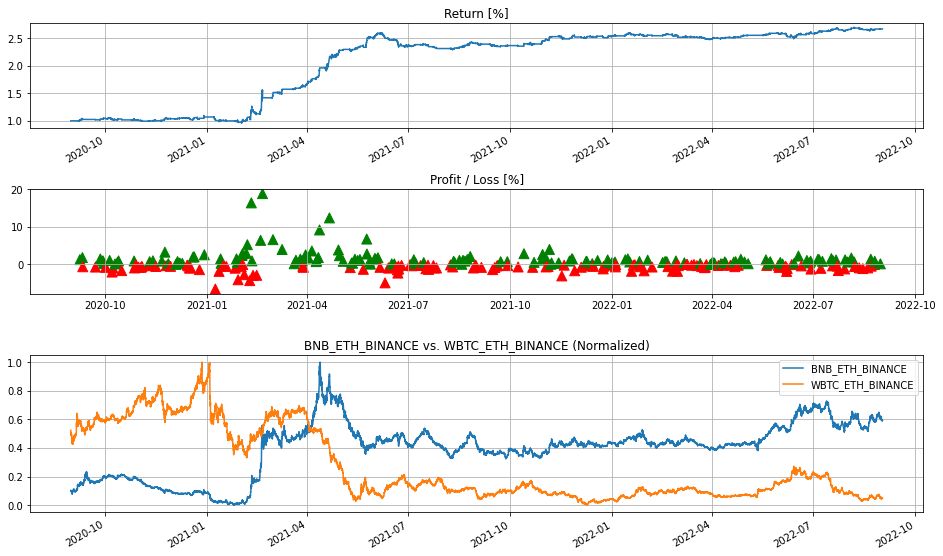

In [26]:
p.visualize_results()

In [27]:
p.performance_metrics.T

,0
Start,2020-08-31 00:00:00
End,2022-09-01 00:00:00
Duration,731 days 00:00:00
Exposure Time [%],30.93
Equity Final [$],26733.977252
Equity Peak [$],27000.52108
Return [%],167.34
Buy & Hold Return [%],224.52
Sharpe Ratio,2.412754
Sortino Ratio,1.713997
